# Perry Pedrosa M6 Software Engineering Summative Assessment

Disclaimer: Due to circumstances out of control, an contextually acceptable Ageas dataset was not available to use, I have used this kaggle dataset within the same industry to substitute. I believe this accurately demonstrates how I would perform this task against an Ageas dataset.

For this task we will be using a motor insurance claim dataset, the dataset consists of various car details and includes whether a claim has been made against their policy. The objectives were to understand any trends that contribute to someone making a claim within the data we capture. We preparedthe data using Pandas; ensuring the structure of the dataset was sound with no invalid values and then transforming our dependent variables into boolean so that we could use it to model. We used numpy and sci-kit learn to analyse our data and evaluate our model. Additionally, Sci-kit learn & statsmodels were used for feature engineering and model selection as the liklihood of class imbalance within our independent variable was evident, so we produced multiple models to account for this and then tested both against metrics and performed model validation tests to understand future feature improvements. Producing these steps in coherence with the software development lifecycle meant we ensured all steps needed to future train the model in a way other developers could follow.
The result showed that is_parking_sensors, subscription_length and vehicle_age were the strongest predictors, although collectively the variables could not produce a robust enough result to confidently say that these predict claims. Future iterations to improve results could mean models like XGBoost may be used to account for imbalance, or sampling with balanced classes be used prior to extrapolation. However, due to the domain context this isnt always possible, using more data will result in a better price rating model overall.


In [ ]:
### The below syntax chunk observes importing relevant libraries & loading my dataset into Python
import numpy as np ### Loaded to handle numerical operations within the syntax
import pandas as pd ### For data manipulation, easy to use data structures, reading the loaded CSV file and statistical summaries
import matplotlib as mat ### To create an array of various visualisations to suite the business need
import matplotlib.pyplot as plt # For plotting visualisations
import seaborn as sns ### For statistical plots if needed, to build on top of matplotlib
import sklearn ### To model my data 
import statsmodels.api as sm # For additional statistical support
from statsmodels.stats.outliers_influence import variance_inflation_factor # To create VIF for independent variables
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, precision_recall_curve, auc, matthews_corrcoef 
from sklearn.model_selection import train_test_split # For further testing using Random Forest
from sklearn.ensemble import RandomForestClassifier
from flask import Flask, request, jsonify
import streamlit as st # To build report
import pickle # To save report
Claims = pd.read_csv("C:\\Users\\Ageas\\Documents\\Data Science Degree\\Software Engineering\\Insurance_Claims_Data.csv")
print(Claims)

       policy_id  subscription_length  vehicle_age  customer_age region_code  \
0      POL045360                  9.3          1.2            41          C8   
1      POL016745                  8.2          1.8            35          C2   
2      POL007194                  9.5          0.2            44          C8   
3      POL018146                  5.2          0.4            44         C10   
4      POL049011                 10.1          1.0            56         C13   
...          ...                  ...          ...           ...         ...   
58587  POL019269                 10.6          2.6            48          C5   
58588  POL001254                  2.3          2.2            37          C3   
58589  POL019859                  6.6          2.2            35          C8   
58590  POL014061                  4.1          3.6            44          C8   
58591  POL054184                  3.1          0.4            49         C12   

       region_density segment model fue

## Data Preparation & Exploration

In [3]:
# The below Syntax chunk observes checking the dataset for null values and transforming selected columns to change from string to boolean and change them to lowercase,
# this is to ensure if any other columns have identical string values that this is not replaced. Although not the most efficiant way, this is to ensure error prevention
#  and clarity of code for users. 
null_values = Claims.isnull().sum()
print(null_values)
columns_to_replace = [
    'is_parking_camera', 'is_esc', 'is_adjustable_steering', 'is_tpms', 
    'is_parking_sensors', 'is_front_fog_lights', 'is_rear_window_wiper', 
    'is_rear_window_washer', 'is_rear_window_defogger', 'is_brake_assist', 
    'is_power_door_locks', 'is_central_locking', 'is_power_steering', 
    'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror', 
    'is_ecw', 'is_speed_alert'
]
for column in columns_to_replace:
    Claims[column] = Claims[column].str.lower().map({'yes': 1, 'no': 0})
print(Claims)


policy_id                           0
subscription_length                 0
vehicle_age                         0
customer_age                        0
region_code                         0
region_density                      0
segment                             0
model                               0
fuel_type                           0
max_torque                          0
max_power                           0
engine_type                         0
airbags                             0
is_esc                              0
is_adjustable_steering              0
is_tpms                             0
is_parking_sensors                  0
is_parking_camera                   0
rear_brakes_type                    0
displacement                        0
cylinder                            0
transmission_type                   0
steering_type                       0
turning_radius                      0
length                              0
width                               0
gross_weight

In [4]:
# The below syntax chunk observes preparing the dataset for the model by selecting the specified columns to use as variables, I am doing this by creating a new data frame called 
# 'Claims_Model'
Claims_Model = Claims[['subscription_length', 'vehicle_age', 'customer_age', 'is_central_locking', 'is_parking_sensors', 'is_parking_camera', 'claim_status']]

print(Claims_Model.head())
print(Claims_Model)

   subscription_length  vehicle_age  customer_age  is_central_locking  \
0                  9.3          1.2            41                   1   
1                  8.2          1.8            35                   1   
2                  9.5          0.2            44                   1   
3                  5.2          0.4            44                   0   
4                 10.1          1.0            56                   1   

   is_parking_sensors  is_parking_camera  claim_status  
0                   1                  1             0  
1                   1                  1             0  
2                   1                  1             0  
3                   1                  0             0  
4                   1                  0             0  
       subscription_length  vehicle_age  customer_age  is_central_locking  \
0                      9.3          1.2            41                   1   
1                      8.2          1.8            35            

## Modelling

Correlation Matrix:
                      subscription_length  vehicle_age  customer_age  \
subscription_length             1.000000     0.166320      0.143350   
vehicle_age                     0.166320     1.000000     -0.035222   
customer_age                    0.143350    -0.035222      1.000000   
is_central_locking              0.229353     0.435211     -0.038549   
is_parking_sensors             -0.015989    -0.023809      0.026342   
is_parking_camera               0.111664     0.228212     -0.039131   
claim_status                    0.078738    -0.028172      0.022234   

                     is_central_locking  is_parking_sensors  \
subscription_length            0.229353           -0.015989   
vehicle_age                    0.435211           -0.023809   
customer_age                  -0.038549            0.026342   
is_central_locking             1.000000           -0.126773   
is_parking_sensors            -0.126773            1.000000   
is_parking_camera              0

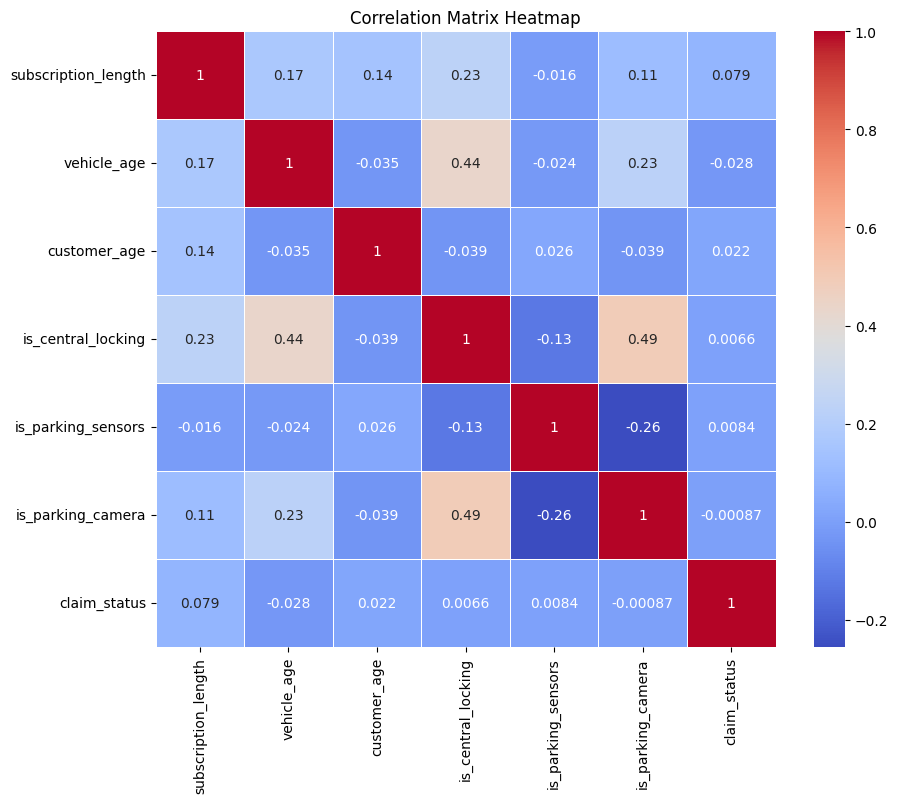

Variance Inflation Factor:
                feature        VIF
0                const  72.954066
1  subscription_length   1.089069
2          vehicle_age   1.244432
3         customer_age   1.028530
4   is_central_locking   1.590740
5   is_parking_sensors   1.072598
6    is_parking_camera   1.394743


In [5]:
# The below syntax chunk observes creating a correlation matrix to check to multicollinearity and visualise it with a correlation heatmap. It shows the plotting of the 
# the creation of a dataframe with 2 columns: 'Feature' which outlines all variables and 'VIF' which produces the corresponding values. Then it shows the the use of plotly
# to create the heatmap, customising the size, palette and layout. Finally, it shows the calculation of the Variance Inflation Factor (VIF) for each independent variable,
#  'X' represents the intercept

correlation_matrix = Claims_Model.corr()
print("Correlation Matrix:\n", correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

X = Claims_Model[['subscription_length', 'vehicle_age', 'customer_age', 'is_central_locking', 'is_parking_sensors', 'is_parking_camera']]
X = sm.add_constant(X)  

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("Variance Inflation Factor:\n", vif_data)

## Summary
The results show a low multicollinearity between the independent variables, meaning no adjustments need to be made prior to fitting the model.


Optimization terminated successfully.
         Current function value: 0.233578
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           claim_status   No. Observations:                58592
Model:                          Logit   Df Residuals:                    58585
Method:                           MLE   Df Model:                            6
Date:                Fri, 03 Jan 2025   Pseudo R-squ.:                 0.01754
Time:                        11:34:50   Log-Likelihood:                -13686.
converged:                       True   LL-Null:                       -13930.
Covariance Type:            nonrobust   LLR p-value:                2.290e-102
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -3.4771      0.148    -23.566      0.000      -3.766      -3.188
su

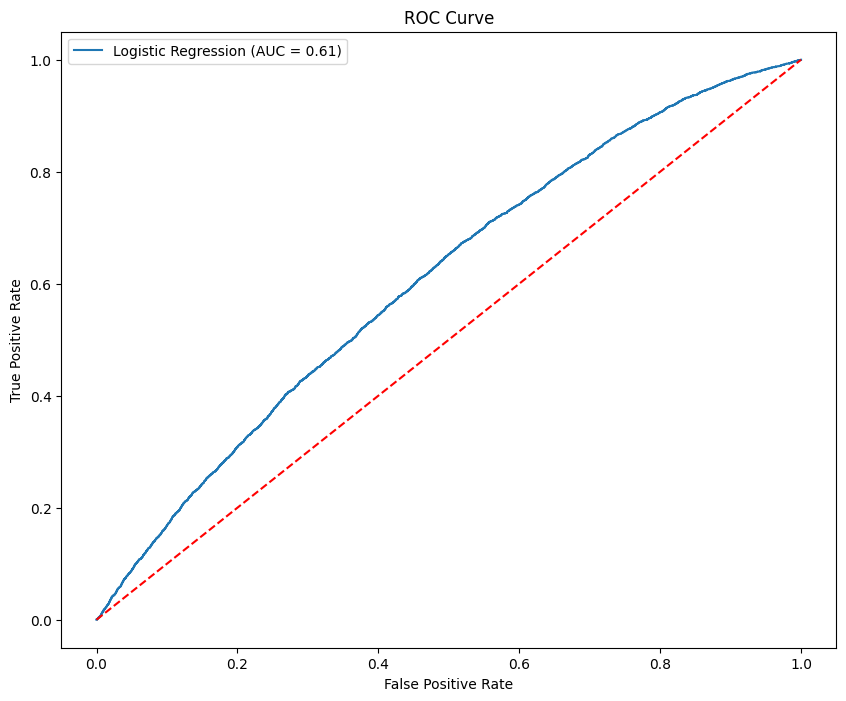

In [6]:
# The below syntax chunk observes the creation of our predictive model by defining the independent variables (X) and the dependent variable (y) for our model. It then shows
# the fitting of the model, setting perameters for predicting probabilities.
X = Claims_Model[['subscription_length', 'vehicle_age', 'customer_age', 'is_central_locking', 'is_parking_sensors', 'is_parking_camera']]
y = Claims_Model['claim_status']
X = sm.add_constant(X)

logit_claims_model = sm.Logit(y, X).fit()
print(logit_claims_model.summary())

claims_predict = logit_claims_model.predict(X)

# We then can see the creation of our receiver operating characteristic curve (ROC) and area under the curve (AUC) and the plotting of the visualisation.
fpr_logit, tpr_logit, thresholds = roc_curve(y, claims_predict)
auc_logit = roc_auc_score(y, claims_predict)

plt.figure(figsize=(10, 8))
plt.plot(fpr_logit, tpr_logit, label=f'Logistic Regression (AUC = {auc_logit:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


Feature Importances:
subscription_length: 0.4736
vehicle_age: 0.1956
customer_age: 0.3101
is_central_locking: 0.0062
is_parking_sensors: 0.0034
is_parking_camera: 0.0110

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     10973
           1       0.07      0.02      0.03       746

    accuracy                           0.92     11719
   macro avg       0.50      0.50      0.50     11719
weighted avg       0.88      0.92      0.90     11719



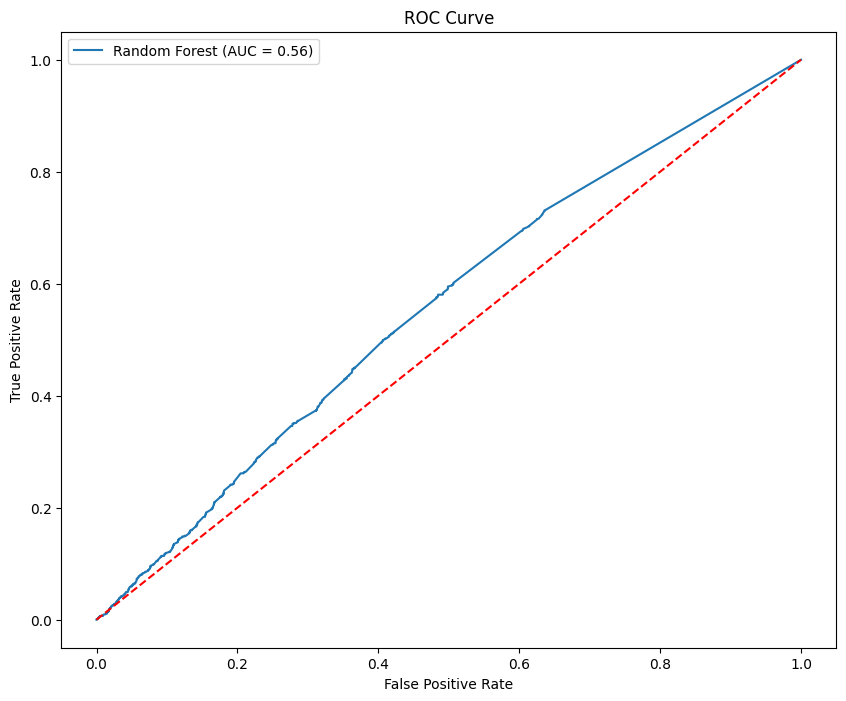

In [7]:
# The below syntax chunk shows a retesting of the model using random forest to compare models. This evidences the fitting of the model and the test train split as well as
# repeating the steps to predict the probabilities and calculation of the receiver operating characteristic curve (ROC) and area under the curve (AUC)
X = Claims_Model[['subscription_length', 'vehicle_age', 'customer_age', 'is_central_locking', 'is_parking_sensors', 'is_parking_camera']]
y = Claims_Model['claim_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

rf_predict = rf_model.predict_proba(X_test)[:, 1]

fpr_rf, tpr_rf, thresholds = roc_curve(y_test, rf_predict)
auc_rf = roc_auc_score(y_test, rf_predict)
# The below syntax chunk shows the assignment of scores to input features based on how useful they are at predicting the claims_model target variable. 
# This helps in understanding which features contribute most to the prediction, leading to better model interpretation. Additionally, it shows the creation of a classification 
# report to evidence to show how well the model is predicting each class which helps understand any weaknesses in the model.

print("Feature Importances:")
for feature, importance in zip(X.columns, rf_model.feature_importances_):
    print(f"{feature}: {importance:.4f}")

y_pred = rf_model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(10, 8))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Optimization terminated successfully.
         Current function value: 0.233405
         Iterations 7
Matthews Correlation Coefficient: 0.0


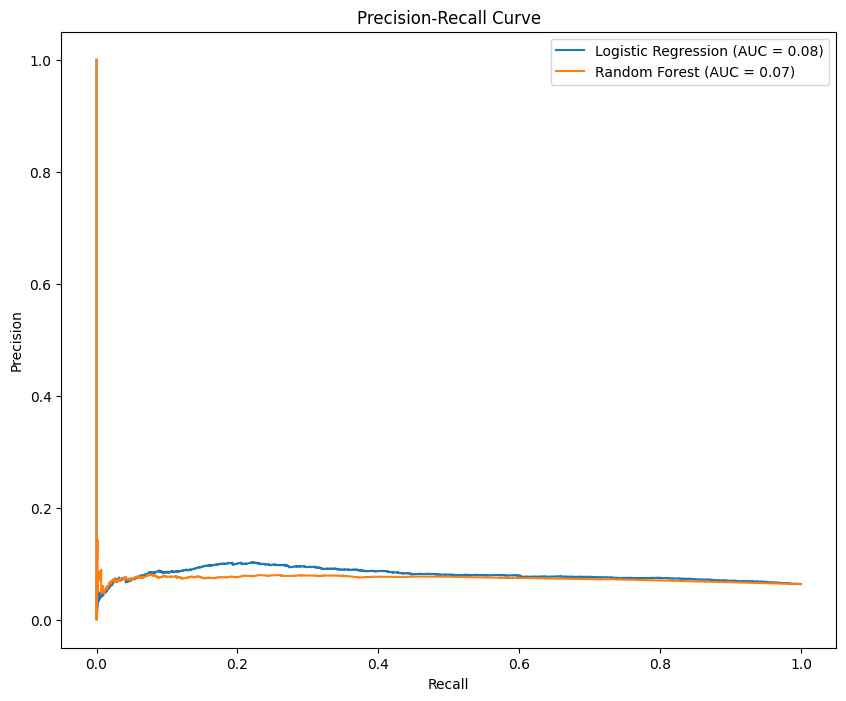

In [8]:
# Finally, we visualise the calculation of the precision recall curve for both logistic regression and random forest models. Additionally, I created a Matthews correlation 
# coefficient to validate the model knowing the classes are imbalanced. Finally, we used Pickle to save our model prior to deployment.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
logit_claims_model = sm.Logit(y_train, sm.add_constant(X_train)).fit()
logit_predict = logit_claims_model.predict(sm.add_constant(X_test))
rf_model.fit(X_train, y_train)
rf_predict = rf_model.predict_proba(X_test)[:, 1]
precision_logit, recall_logit, _ = precision_recall_curve(y_test, logit_predict)
auc_logit = auc(recall_logit, precision_logit)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, rf_predict)
auc_rf = auc(recall_rf, precision_rf)


claims_pred_binary = [1 if prob > 0.5 else 0 for prob in claims_predict]
mcc = matthews_corrcoef(y, claims_pred_binary)
print(f"Matthews Correlation Coefficient: {mcc}")


plt.figure(figsize=(10, 8))
plt.plot(recall_logit, precision_logit, label=f'Logistic Regression (AUC = {auc_logit:.2f})')
plt.plot(recall_rf, precision_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

with open('logit_claims_model.pkl', 'wb') as file:
    pickle.dump(logit_claims_model, file)

# Deployment

It is worth noting here that due to access issues I could not amend my machines environmental variables in order to add Streamlit to my systems path. However, below is an example of how I would have created the report via Streamlit.

In [10]:
# Streamlit app
st.title('Model Performance Dashboard')

st.header('ROC Curve')
fig, ax = plt.subplots()
ax.plot(fpr_logit, tpr_logit, label=f'Logistic Regression (AUC = {auc_logit:.2f})')
ax.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
ax.plot([0, 1], [0, 1], linestyle='--', color='r')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
ax.legend()
st.pyplot(fig)

st.header('Precision-Recall Curve')
fig, ax = plt.subplots()
ax.plot(recall_logit, precision_logit, label=f'Logistic Regression (AUC = {auc_logit:.2f})')
ax.plot(recall_rf, precision_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve')
ax.legend()
st.pyplot(fig)

st.header('Feature Importances (Random Forest)')
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
st.bar_chart(feature_importances)

st.header('Classification Report')
st.text('Logistic Regression:')
st.text(sm.Logit(y_train, sm.add_constant(X_train)).fit().summary())
st.text('Random Forest:')
y_pred_rf = rf_model.predict(X_test)
st.text(classification_report(y_test, y_pred_rf))

# following this in the terminal I would run 'Streamlit run modelreport.py'



2025-01-03 12:05:22.089 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-03 12:05:22.092 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-03 12:05:22.094 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-03 12:05:22.095 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-03 12:05:22.158 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-03 12:05:22.552 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-03 12:05:22.554 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-03 12:05:22.555 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

Optimization terminated successfully.
         Current function value: 0.233405
         Iterations 7


2025-01-03 12:05:23.348 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-03 12:05:23.350 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-03 12:05:23.351 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-03 12:05:23.352 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-03 12:05:23.757 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-03 12:05:23.760 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

# Model Evaluation

### Overall Model Fit
R-squared: 0.01754 tells us that the model explains approximately 1.75% of the variability in the dependent variable. This is a low score and correspondes with an AUC of 0.61 in the visualisation and shows that the model has poor descrimination. An AUC of 0.61 tells us that the independent variables used predict claim_status only slightly better than a 50/50 guess.
### Key Takeaways
Although some variables were more significant than others, the model continues to show a poor fit regardless of retesting using random forest and precision-recall test (which was used due to the imbalance of the y value.)
Although further testing could be done such as resampling techniques to handle the imbalance. However, contextually this is not what we are looking for. We are trying to understand whether certain areas of risk are causing more claims and as a consequence, premiums having to be raised for a certain class of risk. 
As there is no discerable trend in the overall sample, no action needs to be taken.